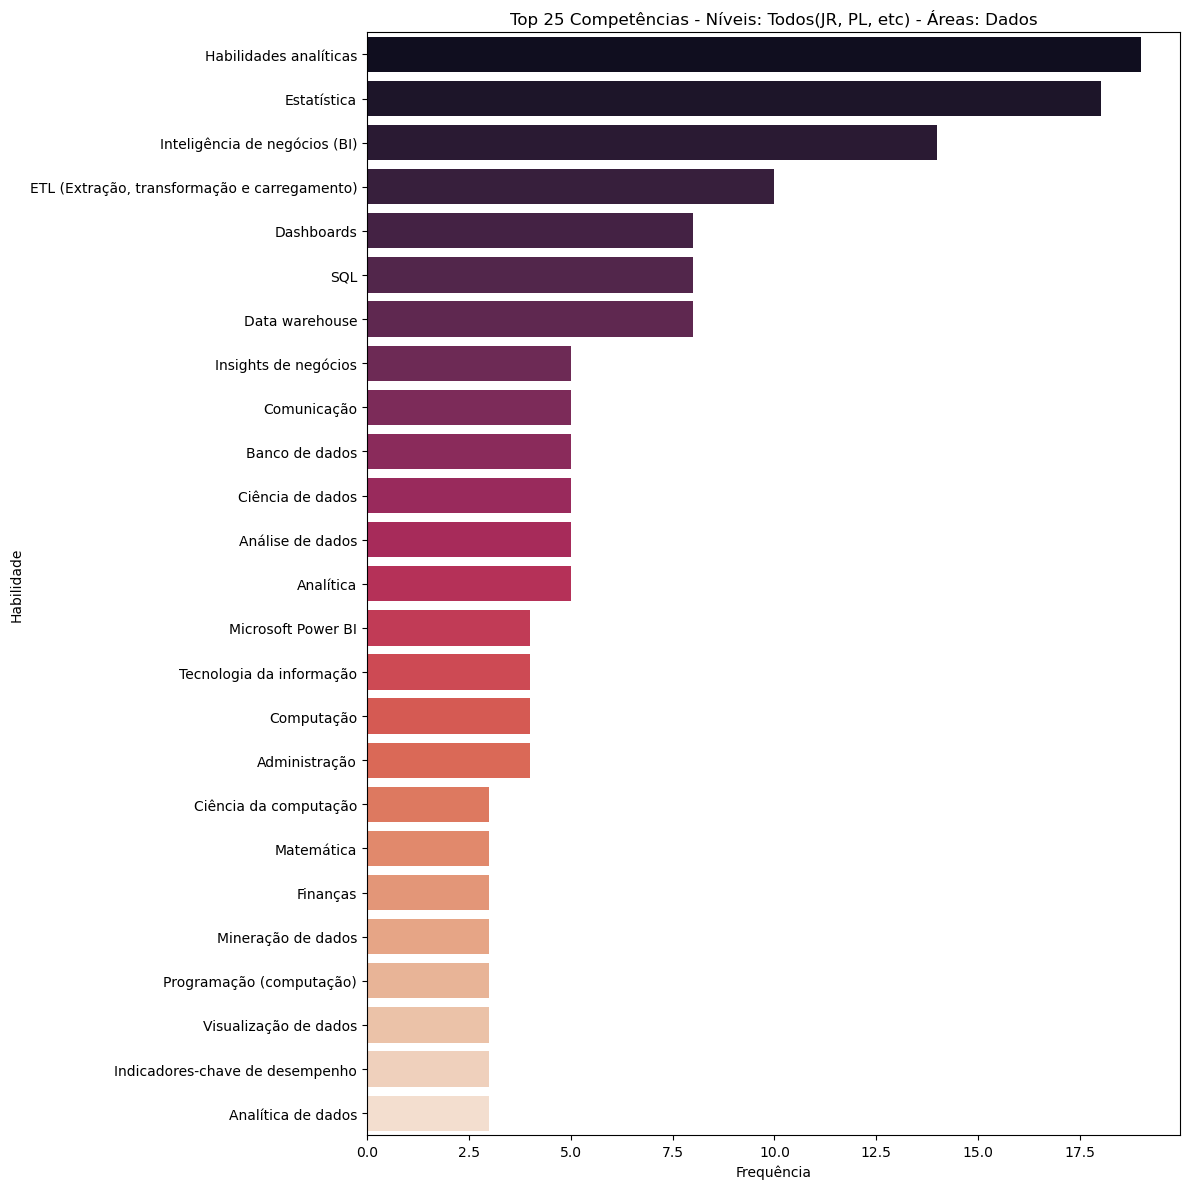

In [1]:
from typing import List, Optional
import pandas as pd
import seaborn as sns
import matpflotlib.pyplot as plt

def load_and_preprocess_data(file_path: str) -> pd.DataFrame:
    """
    Load and preprocess the Excel file, cleaning skill-related data.
    
    Args:
        file_path: Path to the Excel file.
    
    Returns:
        pd.DataFrame: Long-format DataFrame with cleaned skills data.
    
    Raises:
        FileNotFoundError: If the input file is not found.
        ValueError: If no skill columns are found or data is invalid.
    """
    try:
        df = pd.read_excel(file_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"Arquivo {file_path} não encotrado.")
    
    # Usar list comprehension do python para pegar todas as colunas de 
    skill_columns = [col for col in df.columns if 'Habil' in col]
    
    # Transformar em formato longo
    df_long = df.melt(id_vars=['Nível', 'Área'], value_vars=skill_columns, 
                      var_name='Skill_Column', value_name='Skill')
    
    # Limpar dados, remover NaN e strings vazias
    df_long = df_long[df_long['Skill'].notna() & (df_long['Skill'].str.strip() != '')]
    
    # Normalizar casing
    df_long['Nível'] = df_long['Nível'].str.upper()
    df_long['Área'] = df_long['Área'].str.upper()
    
    return df_long

def filter_data(df: pd.DataFrame, levels: Optional[List[str]] = None, 
                areas: Optional[List[str]] = None) -> pd.DataFrame:
    """
    Filter DataFrame by levels and areas.
    
    Args:
        df: Input DataFrame.
        levels: List of job levels to filter (case-insensitive), or None for all.
        areas: List of job areas to filter (case-insensitive), or None for all.
    
    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    filtered = df
    if levels:
        levels = [level.upper() for level in levels]
        filtered = filtered[filtered['Nível'].isin(levels)]
    if areas:
        areas = [area.upper() for area in areas]
        filtered = filtered[filtered['Área'].isin(areas)]
    return filtered

def plot_top_x_skills(df: pd.DataFrame, levels: Optional[List[str]] = None, 
                              areas: Optional[List[str]] = None, x: int = 10, 
                              figsize: tuple = (12, 12), palette: str = 'rocket') -> None:
    """
    Plot top x skills combined across multiple job levels and optional areas.

    Args:
        df: Input DataFrame in long format.
        levels: List of job levels (e.g., ['JR', 'PL']) or None for all.
        areas: List of job areas (e.g., ['Dados', 'Desenvolvimento']) or None for all.
        x: Number of top skills to show (default: 10).
        figsize: Tuple for figure size (width, height).
        palette: Seaborn color palette name.
    
    Example:
        >>> plot_top_x_skills(df, levels=['JR', 'PL'], areas=['Dados'], x=5)
    """
    if x < 1:
        print("Number of skills (x) must be positive.")
        return
    
    # Filtrar dados
    filtered = filter_data(df, levels, areas)
    
    if filtered.empty:
        levels_str = ', '.join(levels) if levels else 'All'
        areas_str = ', '.join(areas) if areas else 'All'
        print(f"Nehuma habilidade encontrada para: {levels_str} e nas áreas: {areas_str}")
        return
    
    # Agrupar por habilidade e contagem
    top_x = (filtered.groupby('Skill')
             .size()
             .reset_index(name='Count')
             .sort_values('Count', ascending=False)
             .head(x))
    
    # Plotar gráfico
    plt.figure(figsize=figsize)
    sns.barplot(data=top_x, x='Count', y='Skill', hue='Skill', palette=palette, legend=False)
    
    levels_str = ', '.join(levels) if levels else 'Todos(JR, PL, etc)'
    areas_str = ', '.join(areas) if areas else 'Todas(Dados, Desenvolvimento, Infraestrutura, etc)'
    plt.title(f"Top {x} Competências - Níveis: {levels_str} - Áreas: {areas_str}")
    plt.xlabel("Frequência")
    plt.ylabel("Habilidade")
    plt.tight_layout()
    plt.show()

try:
    df_long = load_and_preprocess_data('vagas.xlsx')
    plot_top_x_skills(df_long, areas=['Dados'], x=25)
except (FileNotFoundError, ValueError) as e:
    print(f"Error: {e}")